In [1]:
import sys
sys.path.append("..") #import folder which is one level higher

In [2]:
#Workbench imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from workbench_version import * #load the model
from pathlib import Path

from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

from ema_workbench import ema_logging, perform_experiments, MultiprocessingEvaluator

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


### Load results

In [3]:
from ema_workbench import load_results

target = Path("..","temp","experiments")
#experiments, outcomes = load_results(target / "2020_10_23_EMA_experiments_five_hundred.tar.gz")
experiments, outcomes = load_results(target / "2021_2_23_EMA_experiments_five_hundred.tar.gz")

In [4]:
experiments.tail()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario,policy,model
395995,rational,1,4,SurgeHeight\five_hundred\five_hundred_430.csv,Lawkeeper,98995,3,Rotty
395996,rational,3,13,SurgeHeight\five_hundred\five_hundred_453.csv,Lawkeeper,98996,3,Rotty
395997,boundedly_rational,3,10,SurgeHeight\five_hundred\five_hundred_157.csv,Lawkeeper,98997,3,Rotty
395998,boundedly_rational,5,11,SurgeHeight\five_hundred\five_hundred_32.csv,Lawkeeper,98998,3,Rotty
395999,rational,6,4,SurgeHeight\five_hundred\five_hundred_308.csv,Lawkeeper,98999,3,Rotty


In [5]:
experiments2 = experiments.drop(['policy','model'],axis=1)
experiments2.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
0,boundedly_rational,4,12,SurgeHeight\five_hundred\five_hundred_119.csv,R. Active,0
1,boundedly_rational,4,14,SurgeHeight\five_hundred\five_hundred_90.csv,R. Active,1
2,boundedly_rational,2,10,SurgeHeight\five_hundred\five_hundred_220.csv,R. Active,2
3,boundedly_rational,9,9,SurgeHeight\five_hundred\five_hundred_141.csv,R. Active,3
4,rational,5,13,SurgeHeight\five_hundred\five_hundred_7.csv,R. Active,4


In [6]:
list(experiments2["implementation_time"].unique())

[12, 14, 10, 9, 13, 5, 11, 6, 4, 8, 7]

In [7]:
experiments3 = experiments2.copy()

#The discretization function is slightly altered, if you now provide numbers as strings, the categories will
#ordered in ascending order
map_house_market = {'rational' : '1', 
             'boundedly_rational' :'0'}

map_house_market_invert = {'1':'R', 
                           '0':'BR'}

map_mayor = {'H. Economicus': '2',
             'Sentiment' : '1',
             'R. Active' : '0',
             'Lawkeeper' : '3'}

map_mayor_invert = { '2' : 'Economic',
                    '1' : 'Sentiment',
                    '0' : 'Reactive',
                    '3' : 'Proactive'
                    }


rename_cols = {'Housing_market' : 'Housing market (R1)',
               'SLR' : 'SLR scenario (X1)',
               'implementation_time' : 'Implementation time (X3)',
               'transient' : 'Transient storm surge (X2)',
               'Mayor' : 'Management strategy (L1)'}

experiments3['Housing_market'].replace(map_house_market,inplace=True)
experiments3['Mayor'].replace(map_mayor,inplace=True)
experiments3['transient'] = experiments3['transient'].apply(lambda s : int(s.split('_')[-1].split('.')[0]))
cols_convert = ['transient', 'implementation_time']
experiments3[cols_convert] = experiments3[cols_convert].astype('int')
experiments3 = experiments3.rename(columns=rename_cols)
experiments3.head()

,Housing market (R1),SLR scenario (X1),Implementation time (X3),Transient storm surge (X2),Management strategy (L1),scenario
0,0,4,12,119,0,0
1,0,4,14,90,0,1
2,0,2,10,220,0,2
3,0,9,9,141,0,3
4,1,5,13,7,0,4


In [8]:
experiments3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396000 entries, 0 to 395999
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Housing market (R1)         396000 non-null  object  
 1   SLR scenario (X1)           396000 non-null  category
 2   Implementation time (X3)    396000 non-null  int32   
 3   Transient storm surge (X2)  396000 non-null  int32   
 4   Management strategy (L1)    396000 non-null  object  
 5   scenario                    396000 non-null  category
dtypes: category(2), int32(2), object(2)
memory usage: 14.2+ MB


### Dimensional stacking: 
This is a more visual approach to scenario discovery, indicating which combinations of input factors (X) explain outcome metrics of interest (M).

### What explains if SETPs in the City Centre occur before 2200?

In [9]:
x = experiments3
threshold_year = 2200
y = outcomes['CC_first_SETP'] <threshold_year

In [10]:
import ema_workbench.analysis.dimensional_stacking as ds 
import ema_workbench.analysis.feature_scoring as feature_scoring

Change the colormap, inspired from:
https://stackoverflow.com/questions/49367144/modify-matplotlib-colormap

In [11]:
import numpy as np
import matplotlib as mpl
#say we have 1000 different values
n_vals = 256

#variant with black, and color grading from blue to yellow 
upper = mpl.cm.cividis(np.arange(n_vals))
upper[0] = [0,0,0,1] #set the first rgb*alpha* to black

#variant from green to red via yellow
#upper = mpl.cm.YlOrRd(np.arange(n_vals))
#upper[0] = [0,0,0,1] #set the first rgb*alpha* to black


cmap = upper
cmap = mpl.colors.ListedColormap(cmap, name='newmap', N=cmap.shape[0])

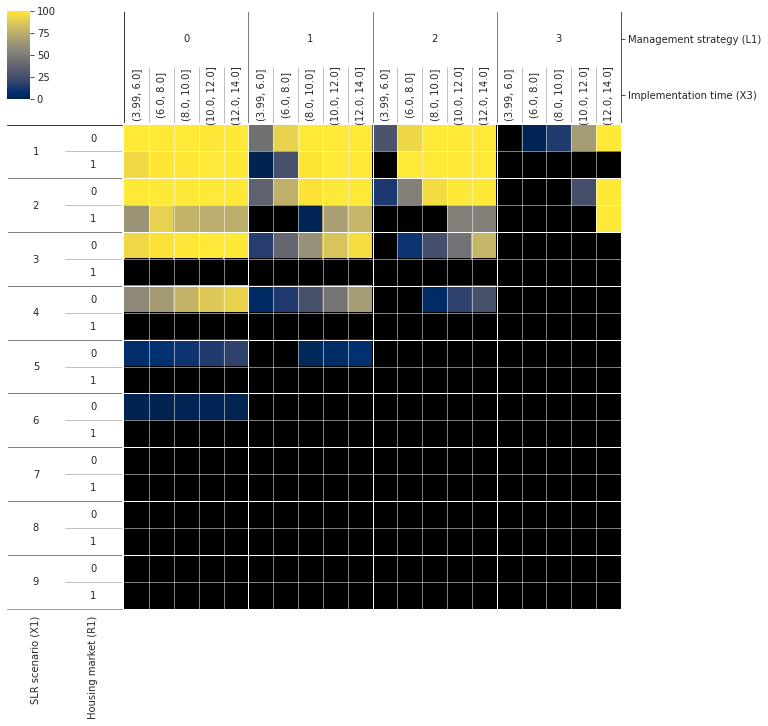

In [32]:
import seaborn as sns

def discretize_new(data, nbins=3, with_labels=False):
    ### Adapted version of the EMA-workbench
    
    ''' Discretize the data, using the number of bins specified.
    Parameters
    ----------
    data : DataFrame
    nbins : int, optional
            the number of bins to use (default is 3)
    with_labels : bool, optional
    Returns
    -------
    discretized
        the discretized data frame
    note:: nbins is currently a constant for all float and integer columns.
           Categorical data is not discretized. If the number of integers is
           lower than the number of bins, the integer variable is also not
           discretized.
    '''
    discretized = data.copy()

    for i, entry in enumerate(data.dtypes):
        column = data.columns[i]
        column_data = data[column]
        n = nbins


        if entry.name == 'category':
            n_unique = column_data.unique().shape[0]
            n = n_unique
            try:
                column_data = column_data.astype('int')
                indices = column_data
            except:
                print('Cannot convert column_data to integer for {}, will therefore rename categories'.format(column_data.name))
                column_data = column_data.cat.rename_categories(
                        [x for x in range(1, n + 1)])
                indices = column_data
            
        else:
            if issubclass(entry.type, np.integer):
                n_unique = column_data.unique().shape[0]
                if n_unique <= n:
                    n = n_unique

            if with_labels:
                indices = pd.cut(column_data, n, precision=2,
                                 retbins=True)[0]
            else:
                indices = pd.cut(column_data, n, retbins=False,
                                 labels=False, precision=2)

        discretized[column] = indices

    return discretized

def create_pivot_plot_new(x, y, nr_levels=3, labels=True, categories=True,
                      nbins=3, bin_labels=True,cmap='cividis'):
    #This is a slightly adapted version of the convenience function in the EMA-workbench
    
    
    x = ds._prepare_experiments(x)
    scores = feature_scoring.get_ex_feature_scores(x, y)[0]
    x = x[scores.index]

    n = nr_levels * 2
    scores = scores.index.tolist()

    #MANUALLY OVERRULLED THESE TO CONTROL LAY-OUT OF FIGURE
    #rows = [entry for entry in scores[0:n:2]]
    #columns = [entry for entry in scores[1:n:2]]
    #print(rows,columns)
    rows = ['SLR scenario (X1)', 'Housing market (R1)'] 
    columns = ['Management strategy (L1)', 'Implementation time (X3)']
    
    discretized_x = discretize_new(x, nbins=nbins, with_labels=bin_labels)

    ooi_label = 'y'
    ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])
    #ooi = 100*ooi

    x_y_concat = pd.concat([discretized_x, ooi], axis=1)
    
    pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows,
                         columns=columns, dropna=False)
    
    #Added to make percentags
    pvt = 100*pvt
    
    #changed vmax 
    fig = plot_pivot_table_new(pvt, plot_labels=labels,
        plot_cats=categories,figsize=(11,11),
        cmap=cmap,vmax=100,annot=False)
    
    return fig,pvt,discretized_x

def plot_pivot_table_new(table, plot_labels=True, plot_cats=True,
                     figsize=(10, 10), cmap='viridis', **kwargs):
    ''' visualize a pivot table using colors
    Parameters
    ----------
    table : Pandas DataFrame
    plot_labels : bool, optional
                 if true, display uncertain factor names
    plot_cats : bool, optional
                 if true, display category labels for each uncertain factor
    fig_size : tuple of 2 ints, optional
               size of the figure to create
    cmap : matplotlib colormap name or object, optional
           default is viridis (requires matplotlib 1.5 or higher)
    kwargs : other keyword arguments
             All other keyword arguments are passed to ax.pcolormesh.
    Returns
    -------
    Figure
    '''

    with sns.axes_style('white'):

        fig = plt.figure(figsize=figsize)

        width_ratios = ds.dim_ratios(figsize=figsize, axis=1)
        height_ratios = ds.dim_ratios(figsize=figsize, axis=0)

        gs = mpl.gridspec.GridSpec(3, 3, wspace=0.01, hspace=0.01,
                                   width_ratios=width_ratios,
                                   height_ratios=height_ratios)

        ax_plot = fig.add_subplot(gs[2, 2])
        ax_rows = fig.add_subplot(gs[2, 0:2], facecolor="white")
        ax_cols = fig.add_subplot(gs[0:2, 2], facecolor="white")
        cax = fig.add_subplot(gs[0, 0])

        # actual plotting
        plot_data = table.values
        sns.heatmap(plot_data, ax=ax_plot, cbar_ax=cax, cmap=cmap, 
                    vmin=0, **kwargs)

        # set the tick labels
        ax_plot.set_xticks([])
        ax_plot.set_yticks([])

        # plot row labeling
        ax_rows.set_ylim(ax_plot.get_ylim())
        ax_rows.set_xlim(0, 1)
        ds.plot_index(ax_rows, ax_plot, axis=1, index=table.index,
                   plot_labels=plot_labels, plot_cats=plot_cats)

        # plot column labeling
        ax_cols.set_xlim(ax_plot.get_xlim())
        ax_cols.set_ylim(0, 1)
        ds.plot_index(ax_cols, ax_plot, axis=0, index=table.columns,
                   plot_labels=plot_labels, plot_cats=plot_cats)

    return fig

fig,pvt,discretized_x = create_pivot_plot_new(x,y, nr_levels=2, nbins=5,categories=True,bin_labels=True,cmap=cmap)

### Now we make the plot slightly nicer by inverting the mapping 

In [33]:
ITs = discretized_x['Implementation time (X3)'].unique() #unique values of implementation times
print(ITs)

[(10.0, 12.0], (12.0, 14.0], (8.0, 10.0], (3.99, 6.0], (6.0, 8.0]]
Categories (5, interval[float64]): [(3.99, 6.0] < (6.0, 8.0] < (8.0, 10.0] < (10.0, 12.0] < (12.0, 14.0]]


In [34]:
#Provide nicer categories for the ITs
map_ITs = {str(ITs[3]) : '4-6',
           str(ITs[4]) : '7-8',
           str(ITs[1]) : '13-14',
           str(ITs[2]) : '9-10',
           str(ITs[0]) : '11-12'}

In [35]:
horizontal_texts = fig._axstack._elements[2][1][1].texts
for i,text in enumerate(horizontal_texts):
    if i % (len(ITs)+1) == 0: #it's a mayor text
        text._text = map_mayor_invert[text._text]
        
    else: #It is an implementation time
            text._text = map_ITs[text._text]

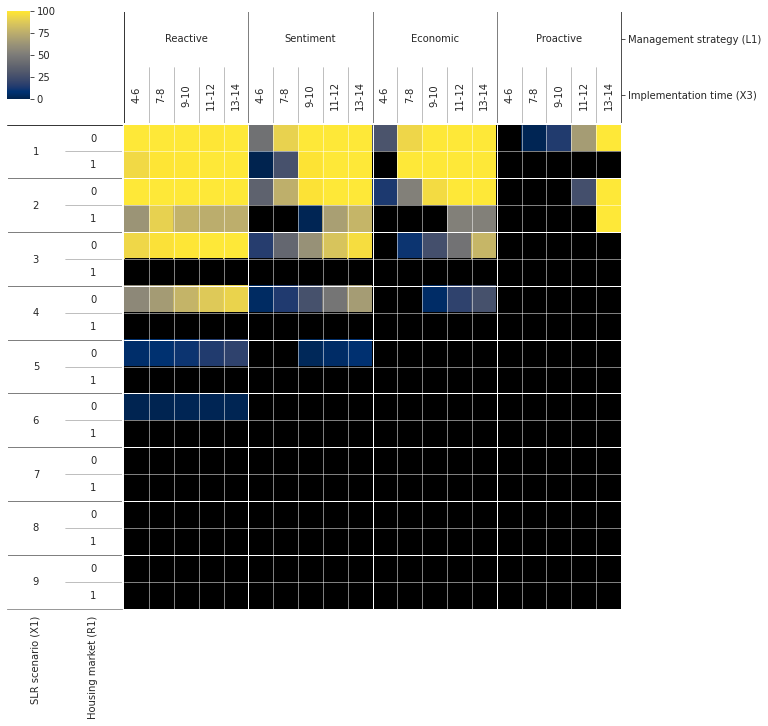

In [36]:
fig

In [37]:
vertical_texts = fig._axstack._elements[1][1][1].texts
for i, text in enumerate(vertical_texts):
    if i % 3 == 0: #number can be divided by three
        pass #don't change the SLR labels
    else:
        text._text = map_house_market_invert[text._text]
        #if text._text == '0': text._text = 'R'
        #elif text._text == '1': text._text =  'BR'

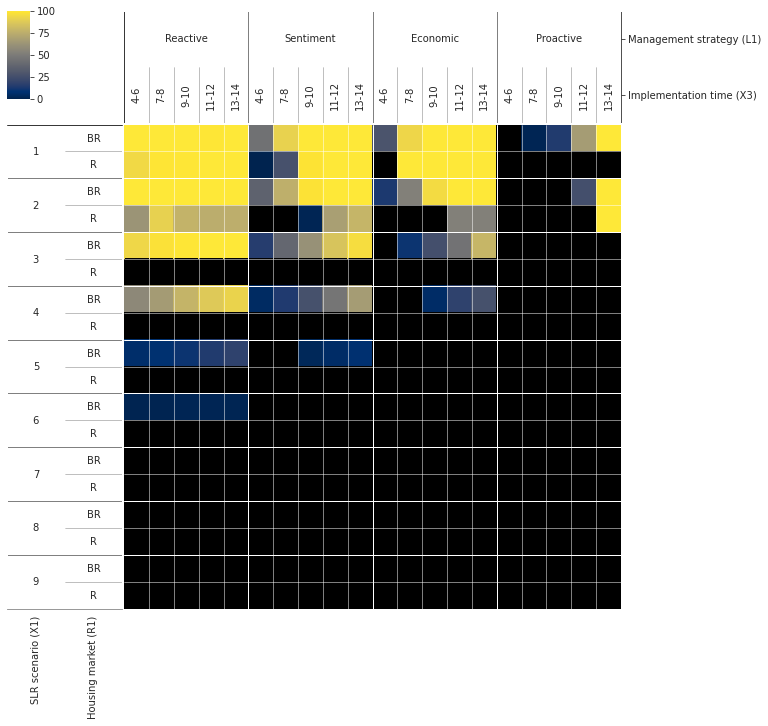

In [38]:
fig

In [39]:
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

target = Path(date)

if not Path.exists(target): Path.mkdir(target)

fig.savefig((target / "Dimstack_fivehundred_CC_below_{}.png".format(threshold_year)),bbox_inches="tight",dpi=200)